In [43]:
%matplotlib notebook

In [44]:
# loading standard modules
import numpy as np
import matplotlib.pyplot as plt
import maxflow
import math

from scipy import ndimage, signal
from skimage import img_as_ubyte
from skimage.color import rgb2grey
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1 import Figure, GraphCutsPresenter

In [45]:
help(maxflow)

Help on package maxflow:

NAME
    maxflow

FILE
    c:\users\jonathan\anaconda2\lib\site-packages\maxflow\__init__.py

DESCRIPTION
    maxflow
    
    ``maxflow`` is a Python module for max-flow/min-cut computations. It wraps
    the C++ maxflow library by Vladimir Kolmogorov, which implements the
    algorithm described in
    
            An Experimental Comparison of Min-Cut/Max-Flow Algorithms for Energy
            Minimization in Vision. Yuri Boykov and Vladimir Kolmogorov. TPAMI.
    
    This module aims to simplify the construction of graphs with complex
    layouts. It provides two Graph classes, ``Graph[int]`` and ``Graph[float]``,
    for integer and real data types.
    
    Example:
    
    >>> import maxflow
    >>> g = maxflow.Graph[int](2, 2)
    >>> g.add_nodes(2)
    0
    >>> g.add_edge(0, 1, 1, 2)
    >>> g.add_tedge(0, 2, 5)
    >>> g.add_tedge(1, 9, 4)
    >>> g.maxflow()
    8
    >>> g.get_segments()
    array([ True, False], dtype=bool)
    
    If you use 

In [54]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)
        
        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]
        self.img = img
        
        # 4-neighbors graph
        self.neighbor_xs = [0, 1]
        self.neighbor_ys = [1, 0]

        # 8-neighbors graph
        #self.neighbor_xs = [0, 1, 1]
        #self.neighbor_ys = [1, 0, 1]

    def run(self):
        self.fig.show()

    def compute_labels(self, seed_mask):   
        num_rows = self.num_rows
        num_cols = self.num_cols
        
        weight_grid = self.weight_grid
        neighbor_xs = self.neighbor_xs
        neighbor_ys = self.neighbor_ys
        num_neighbors = len(neighbor_xs)
        img = self.img
        
        # +---------+---------+
        # |         |         |
        # |   bgr   |  none   |
        # |         |         |
        # +---------+---------+
        # |         |         |
        # |  none   |   obj   |
        # |         |         |
        # +---------+---------+
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        label_mask[:num_rows // 2, :num_cols // 2] = self.bgr_value
        label_mask[num_rows // 2:, num_cols // 2:] = self.obj_value
        
        g = maxflow.Graph[int](num_rows*num_cols, num_rows*num_cols)
        g.add_nodes(num_rows*num_cols)
        
        # Select a 'good' parameter sigma
        # We select sigma based on the standard intensity difference between pixels
        # Considering using median to select outlier resistant measure of centre
        std_r = np.std(img[:,:,0])
        std_g = np.std(img[:,:,1])
        std_b = np.std(img[:,:,2])
        std_rgb = np.array([std_r, std_g, std_b])
        sigma_sqr = np.sum(np.power(std_rgb, 2))
        
        node = 0
        node_d = {}
        
        # Creating nlink and tlinks
        for i in range(num_rows):
            for j in range(num_cols):
                if (i,j) not in node_d:
                    node_d[(i,j)] = node
                    node += 1
                
                val = seed_mask[num_rows, num_cols]
                
                # Add "prohibitively expensive" terminal edge
                if (val == bgr_value or val == obj_value):
                    g.add_tedge(node_d[(i,j)], 10000, 10000)
               
                # Connect with neighbors
                for k in xrange(num_neighbors):
                    nx = i + neighbor_xs[k]
                    ny = j + neighbor_ys[k]
                    
                    # Check valid coordinates
                    if 0 <= nx and nx < num_cols and 0 <= ny and ny < num_rows:
                        if (nx, ny) not in node_d:
                            node_d[(nx, ny)] = node
                            node += 1
                        
                        intensity_diff = np.sum(np.power(img[i, j] - img[nx, ny],2))
                        weight = np.exp(-(intensity_diff/(2*sigma_sqr)))
                        g.add_edge(node_d[(i,j)], node_d[(nx, ny)], weight, weight)
         
        # Calculate max flow
        g.maxflow()
        
        #g.get_segments()
        
        return label_mask

### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

<IPython.core.display.Javascript object>


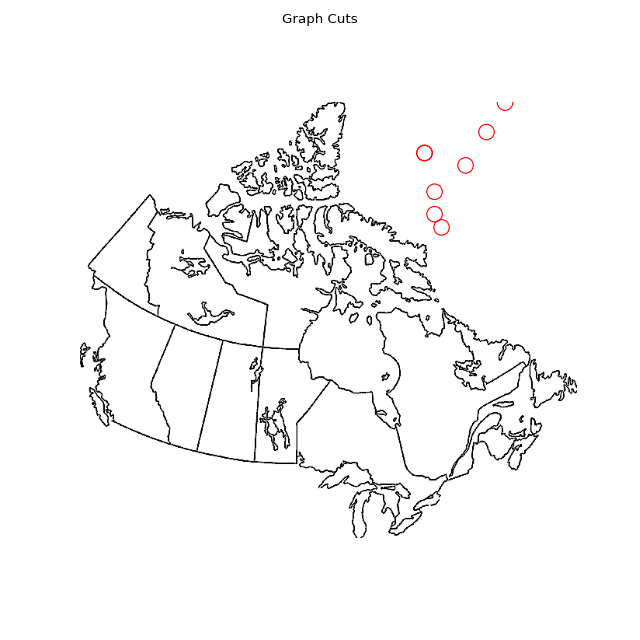

In [55]:
img = plt.imread('images/canada.bmp')
app = MyGraphCuts(img[:800,:800])
app.run()

In [42]:
img = plt.imread('images/bunny.bmp')
#print img[100, 100]
#test = img[:,:,0]
#print np.std(test)
#print test
#print np.std(img[:,:,0])
#print np.std(img[:,:,1])
#print np.std(img[:,:,2])
test = np.array([1,2,3])
test2 = np.array([2,4,6])
print test2 - test
print np.power(test2-test,2)
print np.sum(np.power(test2-test,2))
print np.exp(-2)

[1 2 3]
[1 4 9]
14
0.135335283237
